# Graph Neural Networks by Nourhen Amdouni



---


In this tutorial, we will discuss the application of neural networks on graphs.
This tutorial is based mainly on Dr Jure Leskovec's Stanford course on Graph Neural Network available [here](https://web.stanford.edu/class/cs224w/) and is done in the frame of [an evaluation of the Deep learning coursework](https://openreview.net/group?id=supaerodatascience.github.io/SupaeroSDD/2025/Workshop#tab-recent-activity) of the [Data Science Graduate Program](https://supaerodatascience.github.io/) in ISAE-SUPAERO.


---





## Run this cell to download all images and models needed for explanation in the notebook

In [3]:
#run this cell if you need to delete the downloaded git folder
#!rm -rf /content/DL_images


In [4]:
!git clone https://github.com/Nour19am/DL_images


Cloning into 'DL_images'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 3.82 MiB | 7.09 MiB/s, done.
Resolving deltas: 100% (5/5), done.


## Introduction to graphs

Graphs are ubiquitous in the real world, as many objects can be understood in terms of their relationships with other entities. The connections between a set of objects are inherently represented as a graph. For over a decade, researchers have been developing neural networks capable of processing graph data, known as graph neural networks (GNNs). Recent advancements have significantly enhanced their capacity and expressive power. As a result, we are witnessing their practical applications in various fields, including antibacterial discovery, physics simulations, fake news detection, traffic prediction, and recommendation systems.

Many types of data can be treated as graphs:

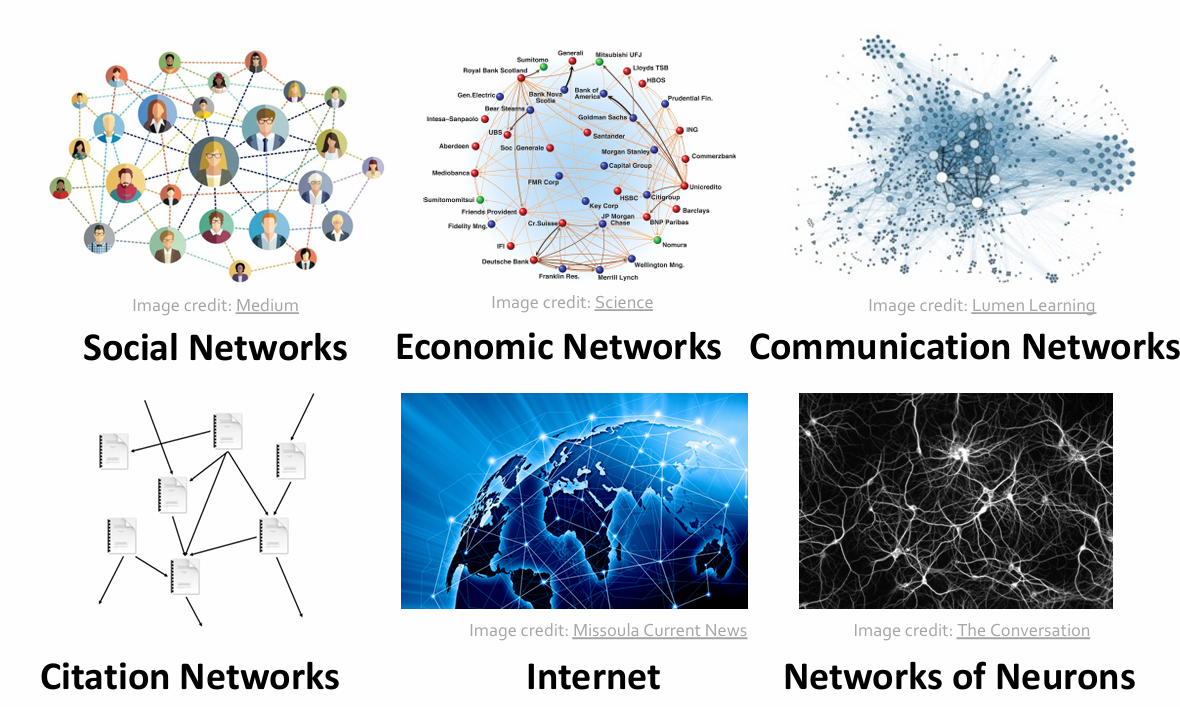

In [6]:
from IPython.display import Image
Image(filename='/content/DL_images/everywhere.png', width=600)

But what is first a graph?

Mathematically, a graph G is defined as:

$G=(V,E,R,T)$ where
* Nodes with node types 𝑣 ∈ 𝑉
* Edges with relation types $(v_i,r,v_j) \in E$
* Node type $T(v_i)$
* Relation type 𝑟 ∈ 𝑅

Nodes and edges have attributes/features:

*  Social networks: User profile, User image
*  Biological networks: Gene expression profiles, gene
functional information

Graphs could be directed (edges have directions and represented by arrows. Here the order matters) or undirected (edges are simply represented by lines).

An undirected graph can be considered a special case of a directed graph where:

* Every edge (A, B) is bi-directional (meaning both A → B and B → A exist).
* There is no inherent directionality, but we can represent it using two directed edges.



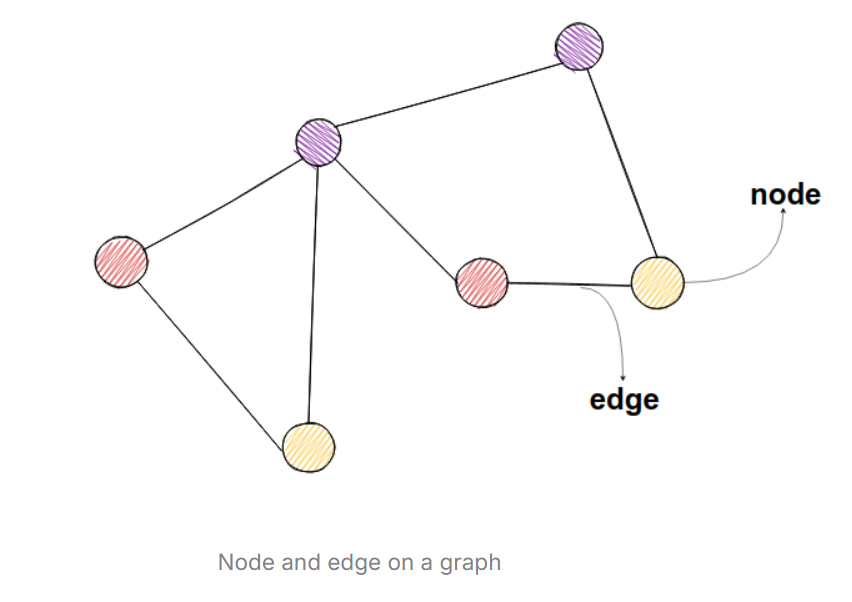

In [ ]:
Image(filename='/content/DL_images/graph_general.png', width=600)

Graphs can capture very rich relationships as it is the case for   Heterogeneous Graph Network (HGNN) where:

* Multiple types of nodes exist (e.g., users, products, reviews).
* Multiple types of edges exist (e.g., "buys," "reviews," "related to").


HGNNs are useful in recommendation systems, social networks, and knowledge graphs because they capture rich relationships.

An example is shown below where an e-commerce website is represented by a graph such that:

* Users buy articles (products).
* Users write reviews for articles.
* Articles are linked to other similar articles.

This creates a heterogeneous graph with three node types and three edge types.

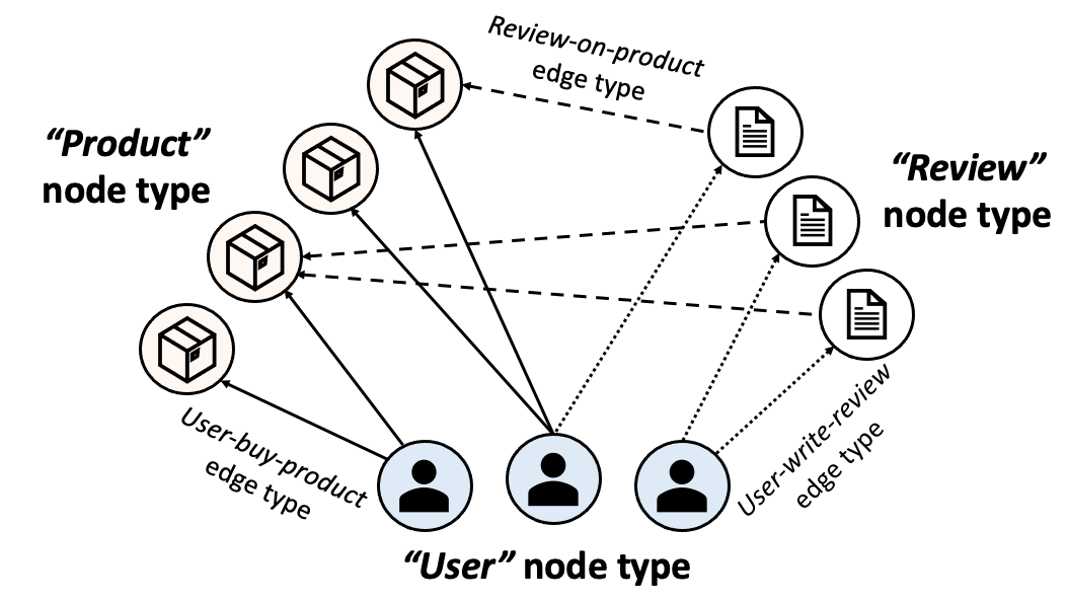

In [ ]:
Image(filename='/content/DL_images/heteregenous.png', width=600)

But Networks are **complex**. They have arbitrary size and complex topological structure (i.e., no spatial locality like grids). They do not have fixed node ordering or reference point and are often  dynamic and have multimodal features

In the **traditional machine learning** realm, given an input graph,we extract node, link
and graph-level features, then the model (SVM, neural network, etc.) learns to maps features to labels. The problem is that in Graph Representation Learning we need to do feature engineering every
single time.

**The goal** would be to efficiently perform task-independent feature
learning for machine learning with graphs!

So the **task** is to map nodes into an embedding space to encode network information and potentially use it for many downstream predictions like node and graph classification..

Indeed, there are different levels of classification as shown below:

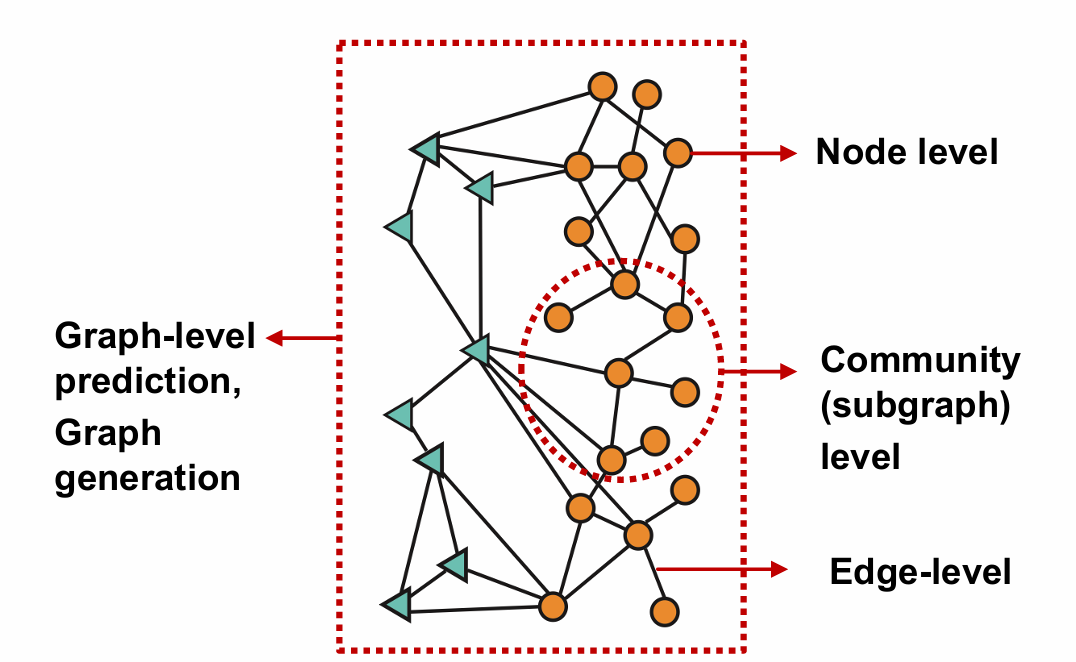

In [ ]:
Image(filename='/content/DL_images/graph prediction.png', width=600)



---


In this notebook we wil be focusing mainly on:


1.   manipulating graphs using **NetworkX** and **PyTorch Geometric**
2.   performing simple node embedding using a simple similarity criterion
3.   implementing a Graph Convolutional Network (GCN) to perform node-level and graph-level classification on datasets taken from **ogb**



---



##  First steps with graphs using NetworkX and PyTorch Geometric



---


We will use two packages, [NetworkX](https://networkx.org/documentation/stable/) and [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)

**NetworkX** is one of the most frequently used Python packages to create and manipulate graphs


---




### setup

In [ ]:
import networkx as nx

In [ ]:
# Install torch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.1 MB/s eta 0:00:00


### First simple graph manipulation

**Important disclaimer:** We will be using two objects **G** the networkX graph and **data** the pytorch geormetric object, a format optimized for deep learning on graphs. Indeed we convert **G** to **data** to process it with machine learning models later. Both represent the same underlying graph, but they serve different purposes

Here, we create our own graph to use it for **nodes embedding** in the next section

In [ ]:
from torch_geometric.utils import from_networkx

# Create 3 clusters of nodes
G1 = nx.complete_graph(6)  # Cluster 1 (6 nodes, fully connected)
G2 = nx.complete_graph(7)  # Cluster 2 (7 nodes, fully connected)
G3 = nx.complete_graph(5)  # Cluster 3 (5 nodes, fully connected)
# Connect the clusters
G = nx.disjoint_union(G1, G2)  # Combine clusters into a single graph
G = nx.disjoint_union(G, G3)  # Combine clusters into a single graph
G.add_edge(0, 7)  # Add an edge between nodes in different clusters
G.add_edge(15,11)
G.add_edge(17,5)
G.add_edge(0,11)


Data(edge_index=[2, 100], num_nodes=18)
False


NetworkX also provides tooling to visualize graphs.

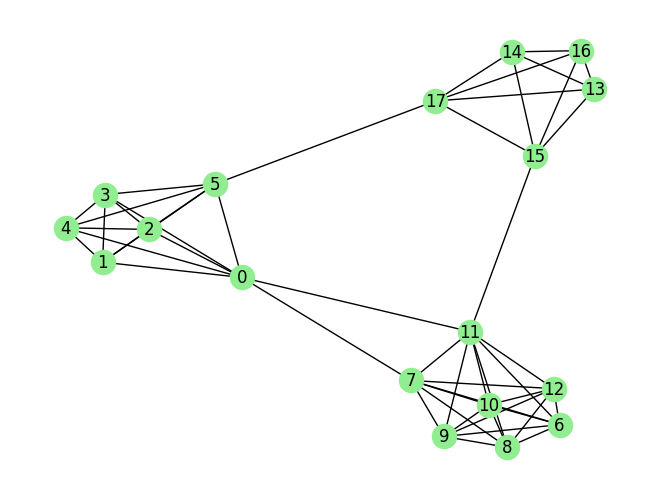

In [ ]:
nx.draw(G,with_labels=True,node_color='lightgreen')

Let's now look at the graph in more detail.
`data = from_networkx(G)` is a function call from PyTorch Geometric that converts graph G into a PyTorch Geometric Data object. This is useful when working with Graph Neural Networks (GNNs) using PyTorch Geometric.

In [ ]:
# Convert to Torch Geometric's Data object
data = from_networkx(G)
print(data)
print('------------------------------------------')
# Some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 100], num_nodes=18)
------------------------------------------
Number of nodes: 18
Number of edges: 100
Average node degree: 5.56
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
import torch
print(torch.__version__)

2.5.1+cu124


`G.nodes[node]['x']` is used in NetworkX to access the attribute 'x' of a specific node in the graph G. More specifically, `G.nodes` refers to the collection of nodes in the graph, `G.nodes[node]` accesses a dictionary containing all attributes of a specific node and `G.nodes[node]['x']` retrieves the value of the attribute 'x' for that node.

In [ ]:
# Add random node features
for node in G.nodes():
    # Random 10-dimensional features
    G.nodes[node]['x'] = torch.randn(10).tolist()  # Random 10-dimensional features

In [ ]:
# Get attributes of the node 0
node_0_attr = G.nodes[0]
print("Node 0 has the attributes {}".format(node_0_attr))

Node 0 has the attributes {'x': [0.19459168612957, -1.5091944932937622, -1.3902736902236938, -1.1827231645584106, 0.8802266716957092, -1.4970083236694336, 1.5545443296432495, 0.08987674117088318, -0.6357492804527283, 0.14148642122745514]}


Below `assign_cluster(x)` maps values to clusters, then  `nx.set_node_attributes(G, clusters, 'cluster')` assigns these clusters as node attributes in the NetworkX graph G so that we train later an embedding model to classify nodes into clusters.

In [ ]:
def assign_cluster(x):
    if x < 6:
        return 0
    elif 6 <= x <= 12:
        return 1
    elif 13 <= x <= 18:
        return 2
    else:
        return -1  # Default or out-of-range cluster
clusters = {x:assign_cluster(x) for x in range(18)}
nx.set_node_attributes(G, clusters, 'cluster')

In [ ]:
# see the cluster number of node 0
G.nodes[0]['cluster']

0

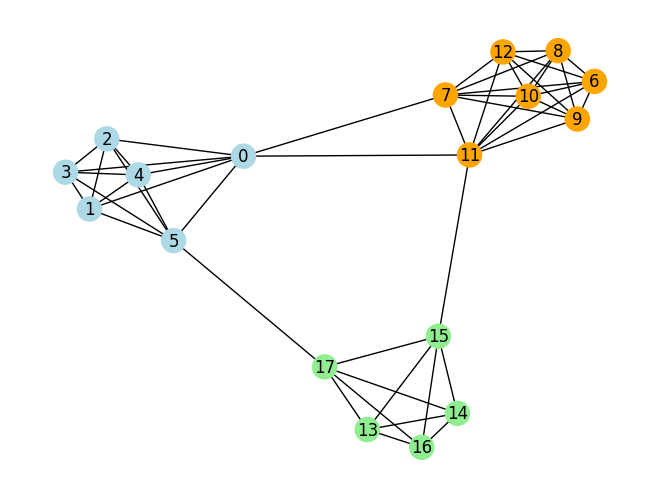

In [ ]:
# Map clusters to colors
color_map = {0: 'lightblue', 1: 'orange',2:'lightgreen'}
node_colors = [color_map[G.nodes[node]['cluster']] for node in G.nodes()]

# Draw the graph with colored nodes
nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

Next we'll print the `edge_index` of our graph:

In [ ]:
edge_index = data.edge_index
print(edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,
          9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
         12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15,
         15, 16, 16, 16, 16, 17, 17, 17, 17, 17],
        [ 1,  2,  3,  4,  5,  7, 11,  0,  2,  3,  4,  5,  0,  1,  3,  4,  5,  0,
          1,  2,  4,  5,  0,  1,  2,  3,  5,  0,  1,  2,  3,  4, 17,  7,  8,  9,
         10, 11, 12,  6,  8,  9, 10, 11, 12,  0,  6,  7,  9, 10, 11, 12,  6,  7,
          8, 10, 11, 12,  6,  7,  8,  9, 11, 12,  6,  7,  8,  9, 10, 12, 15,  0,
          6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 13, 15, 16, 17, 13, 14, 16, 17,
         11, 13, 14, 15, 17, 13, 14, 15, 16,  5]])


`edge_index = data.edge_index` extracts the edge connectivity from the PyTorch Geometric Data object. This is a tensor representation of the graph structure, where `edge_index[0]` contains the source nodes of edges and `edge_index[1]` contains the target nodes of edges.


`edge_index.T.tolist()` outputs the edge list in a format that is easier to read. It represents the edges in the graph as a list of (source, target) pairs.

In [ ]:
print(edge_index.T.tolist())

[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [0, 11], [1, 0], [1, 2], [1, 3], [1, 4], [1, 5], [2, 0], [2, 1], [2, 3], [2, 4], [2, 5], [3, 0], [3, 1], [3, 2], [3, 4], [3, 5], [4, 0], [4, 1], [4, 2], [4, 3], [4, 5], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 17], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [6, 12], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [7, 12], [7, 0], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [8, 12], [9, 6], [9, 7], [9, 8], [9, 10], [9, 11], [9, 12], [10, 6], [10, 7], [10, 8], [10, 9], [10, 11], [10, 12], [11, 6], [11, 7], [11, 8], [11, 9], [11, 10], [11, 12], [11, 15], [11, 0], [12, 6], [12, 7], [12, 8], [12, 9], [12, 10], [12, 11], [13, 14], [13, 15], [13, 16], [13, 17], [14, 13], [14, 15], [14, 16], [14, 17], [15, 13], [15, 14], [15, 16], [15, 17], [15, 11], [16, 13], [16, 14], [16, 15], [16, 17], [17, 13], [17, 14], [17, 15], [17, 16], [17, 5]]


We can also extract the pairs of edges from the NetworkX graph G and store them as a Python list of tuples, where each tuple represents an edge (source, target).

In [ ]:
edge_list=list(G.edges)
print(edge_list)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 11), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (5, 17), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (8, 9), (8, 10), (8, 11), (8, 12), (9, 10), (9, 11), (9, 12), (10, 11), (10, 12), (11, 12), (11, 15), (13, 14), (13, 15), (13, 16), (13, 17), (14, 15), (14, 16), (14, 17), (15, 16), (15, 17), (16, 17)]


You can run this cell multiple times. Guess why the result sometimes changes for an edge that can be or not a negative one?

In [ ]:
import random

def graph_to_edge_list(G):
  edge_list=list(G.edges)
  return edge_list



def edge_list_to_tensor(edge_list):
  edge_index = torch.tensor(edge_list).T
  edge_index = edge_index.type(torch.long)
  return edge_index



def sample_negative_edges(G, num_neg_samples):
    positive_edges = set(G.edges())
    nodes = list(G.nodes())

    # Generate all possible edges (excluding self-loops)
    all_possible_edges = set((u, v) for u in nodes for v in nodes if u != v and u < v)

    # Compute negative edges (edges not in the graph)
    neg_edge_list = list(all_possible_edges - positive_edges)

    # Randomly sample the required number of negative edges
    neg_edge_list = random.sample(neg_edge_list, num_neg_samples)

    return neg_edge_list


pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
# Sample negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (13, 11)
edge_3 = (14, 0)


def can_be_negative(G, edge):
  is_negative= False
  if edge in sample_negative_edges(G,G.number_of_edges()):
    is_negative=True
  return is_negative

print(f"Edge 1 can be a negative edge: {can_be_negative(G, edge_1)}")
print(f"Edge 2 can be a negative edge: {can_be_negative(G, edge_2)}")
print(f"Edge 3 can be a negative edge: {can_be_negative(G, edge_3)}")


The neg_edge_index tensor has shape torch.Size([2, 50])
Edge 1 can be a negative edge: False
Edge 2 can be a negative edge: False
Edge 3 can be a negative edge: False


`sample_negative_edges` samples a new set of negative edges each time it's called, which means the same edge might be negative in one call but not in another.

Instead of resampling negative edges, simply check if the edge exists in the graph.

In [ ]:
def can_be_negative(G, edge):
    # Check if the edge is NOT in the graph G
    return edge not in G.edges()


In [ ]:
# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (13, 11)
edge_3 = (14, 0)
print(f"Edge 1 can be a negative edge: {can_be_negative(G, edge_1)}")
print(f"Edge 2 can be a negative edge: {can_be_negative(G, edge_2)}")
print(f"Edge 3 can be a negative edge: {can_be_negative(G, edge_3)}")

Edge 1 can be a negative edge: True
Edge 2 can be a negative edge: True
Edge 3 can be a negative edge: True


`sample_negative_edges` would be useful later for training the graph neural network so let's keep  it for later

## Node embedding



---


After learning about PyTorch Geometric's data handling, it's time to implement our first model to classify nodes using **Node embedding**.

The goal is for nodes that have similar roles in the graph to be represented by similar vectors in the embedding space


---





Embeddings should capture the graph topology, relationships between nodes and further relevant information.

A possible shortcut to this problem is to try to form embeddings such that node embeddings of two nodes are similar in some sense, if they happen to have some similarity in the real network.



We need to define a **similarity function** that specifies how the
relationships in vector space map to the relationships in the original network. We chose to define the similiarity between two nodes $u$ and $v$ as the scalar product between their respective embedding vectors as follows: $similarity (u,v) ≈ z_v^{T} z_u$



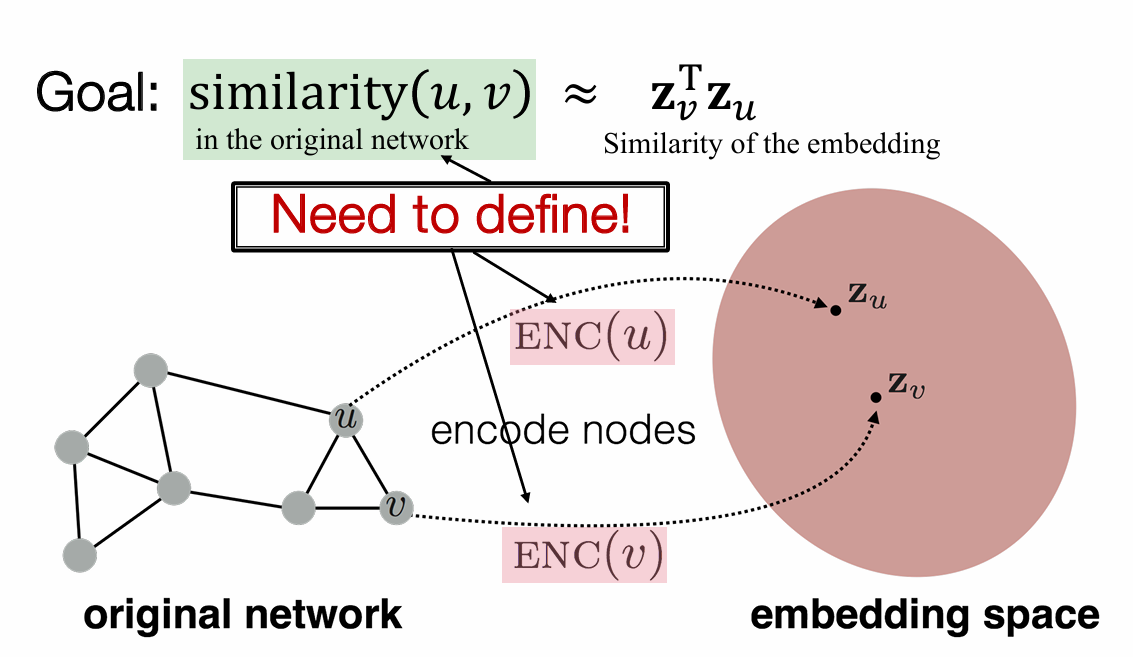

In [ ]:
Image(filename='/content/DL_images/node_embedding_scalar_product.png', width=600)

In PyTorch, `nn.Embedding` is a class that provides an embedding layer, which is typically used to map discrete input values to continuous vector representations

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=18, embedding_dim=3):
  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
  #extract the shape of the weights
  shape = emb.weight.data.shape
  #assign random weights
  emb.weight.data = torch.rand(shape)


  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 4])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 4
print(emb(ids))

Embedding: Embedding(18, 3)
tensor([[0.7720, 0.3828, 0.7442],
        [0.5304, 0.4148, 0.7937]], grad_fn=<EmbeddingBackward0>)


Let's visualize the initial random embedding

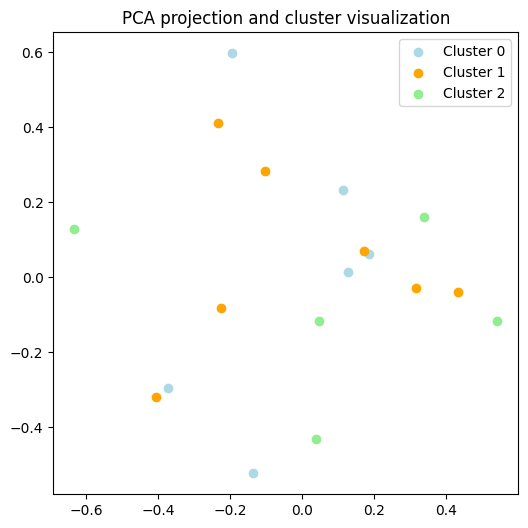

In [ ]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  cluster0_x = []
  cluster0_y = []

  cluster1_x = []
  cluster1_y = []

  cluster2_x = []
  cluster2_y = []

  for node in G.nodes(data=True):
    if node[1]['cluster'] == 0:
      cluster0_x.append(components[node[0]][0])
      cluster0_y.append(components[node[0]][1])
    elif node[1]['cluster'] == 1:
      cluster1_x.append(components[node[0]][0])
      cluster1_y.append(components[node[0]][1])
    else:
      cluster2_x.append(components[node[0]][0])
      cluster2_y.append(components[node[0]][1])
  plt.scatter(cluster0_x, cluster0_y, color="lightblue", label="Cluster 0")
  plt.scatter(cluster1_x, cluster1_y, color="orange"  , label="Cluster 1")
  plt.scatter(cluster2_x, cluster2_y, color="lightgreen", label="Cluster 2")
      # Add node labels to the plot
  plt.title('PCA projection and cluster visualization')
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observe how the embeddings react.
Here, we simply train against one node per class, but are allowed to make use of the complete input graph data which is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
Where we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).
We initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code)

For each epoch:
*   we compute the node embeddings for the edges in train_edge.
*   we calculate the dot product between the corresponding node pairs (u.T @ v).
*   Then, we apply the sigmoid activation to the dot product to get the prediction.
*   The loss is computed using loss_fn, and the optimizer steps to update the model.

In [ ]:
from torch.optim import SGD
import torch.nn as nn
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))

def accuracy(pred, label):

  predicted=torch.where(pred>0.5,1,0)
  predicted=predicted.type(torch.long)
  accu=round((predicted==label).sum().item()/len(pred),4)

  return accu

def train(emb, loss_fn, train_label, train_edge):

  epochs = 200
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):

     optimizer.zero_grad() # Clear gradients.
     out = emb(train_edge) # Get the embeddings of the nodes in train_edge
     nodes1=out[0,:,:]
     nodes2=out[1,:,:]
     z_list=torch.zeros(len(nodes1))
     i=0
     for u,v in zip(nodes1,nodes2):
      z=u.T@v #dot product between each node pair
      z_list[i]=z
      i=i+1
     out_sig=torch.sigmoid(z_list)
     loss = loss_fn(out_sig, train_label)
     loss.backward() # Compute gradients.
     optimizer.step() # Update parameters based on gradients.

     print("loss is ",loss,"accuracy is ",accuracy(out_sig, train_label))


  return emb

loss_fn = nn.BCELoss()

print(pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, train_label, train_edge)

<IPython.core.display.Javascript object>

torch.Size([2, 50])
torch.Size([2, 100])
loss is  tensor(0.8067, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.8054, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.8028, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5


<ipython-input-79-1b0c61bf7cca>:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  z=u.T@v #dot product between each node pair


loss is  tensor(0.7992, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.7947, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.7896, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.7839, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.7779, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.7717, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.7653, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.7589, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.5
loss is  tensor(0.7525, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.49
loss is  tensor(0.7463, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.49
loss is  tensor(0.7402, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.49
loss is  tensor(0.7344, grad_fn=<BinaryCrossEntropyBackward0>) accuracy is  0.49
loss is  tensor(0.7287, grad_fn=<Bin

Embedding(18, 3)

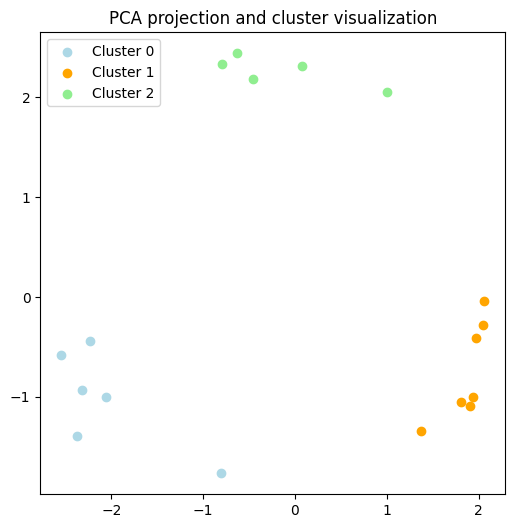

In [ ]:
# Visualize the final learned embedding
visualize_emb(emb)

As one can see, The embedding manages to separate the communities pretty well and classify most of the nodes correctly.


Allthough this node embedding also knwon as shallaow embedding seems to be effective and simple, it cannot generate embeddings for nodes that are not seen during training, there is no sharing of parameters between nodes, every node has its own unique embedding.  We will later use multiple layers of non-linear transformations based on graph structure to generate embedding that could be used to predict for data not in the training set.

## GCN



---


In this section we will use GCN as the foundation for the graph neural network. We will work with PyG's built-in GCNConv layer.


---



### Overview

At this point, let us remind ourselves about the output of a GNN and what is it used for?

The goal of a GNN is to take an input graph $G = (\mathbb{V}, \mathbb{E})$ where each node $v_i \in \mathbb{V}$ has an input feature vector $X_i^{(0)}$. What we want to learn is a function $f_G : \mathbb{V} \times \mathbb{R}^{d_1} \to \mathbb{R}^{d_2} $, a function that takes in a node and its feature vector, as well as the graph structure, and outputs an _embedding_, a vector that represents that node in a way that's useful to our downstream task. Once we've mapped nodes and their initial features to their learned embeddings, we can use those embeddings to do a variety of different tasks including node-level, edge-level, or graph-level regression/classification.
We will use one of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)).
**The goal is to generalize convolutions** beyond simple lattices Leverage node features/attributes (e.g., text, images).



Traditional neural networks work well with grid-like data structures, such as images or sequences, but graphs are more complex and irregular. GCNs allow us to generalize neural networks to operate on these irregular structures.

Our goal is to build a deep convolutional neural netwrok adapted for graphs as below:

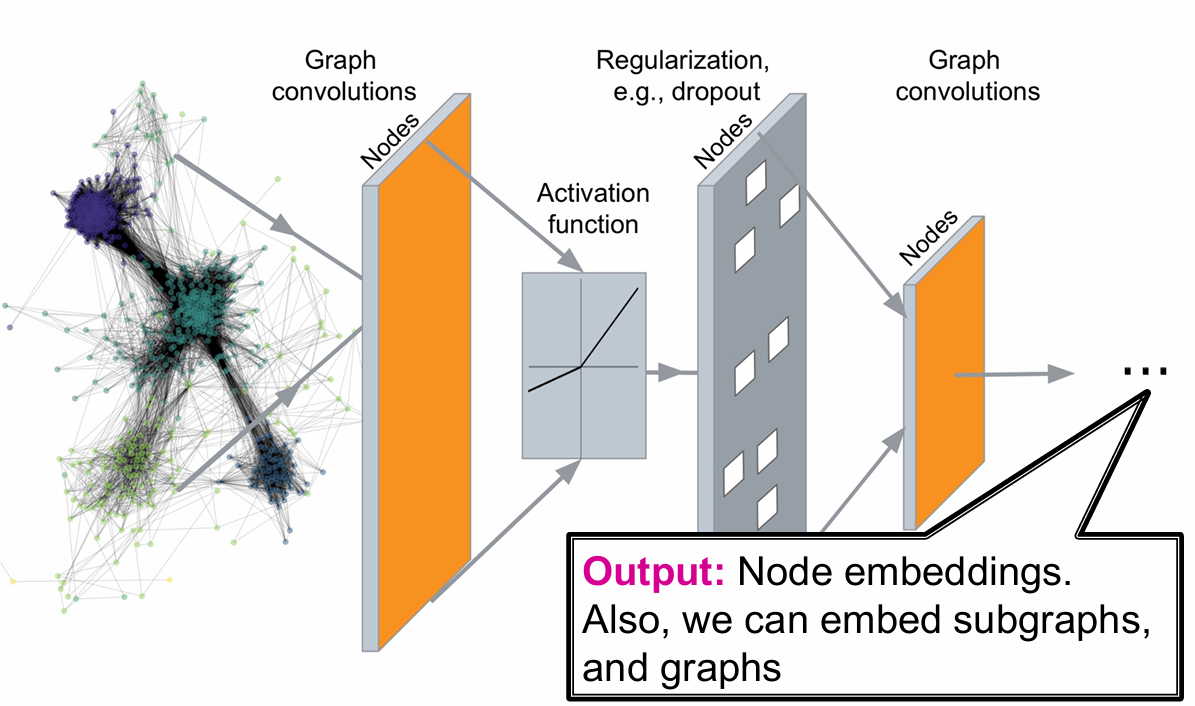

In [7]:
Image(filename='/content/DL_images/GCN_general.png', width=600)

In GCNs, each node aggregates information from its neighbors to update its own feature representation. This process is called message passing.
The aggregation typically involves summing, averaging, or applying a neural network layer to combine the features of neighboring nodes. (**see image below, subfigure (a)**)

Every node defines a computation graph based on its neighborhood (**see image below, subfigure (b)**)

One can choose which depth $k$ of neighborhs to go to (**see image below, subfigure (b)**). Each layer-k embeddings gets information from nodes that are $k$ hops away.

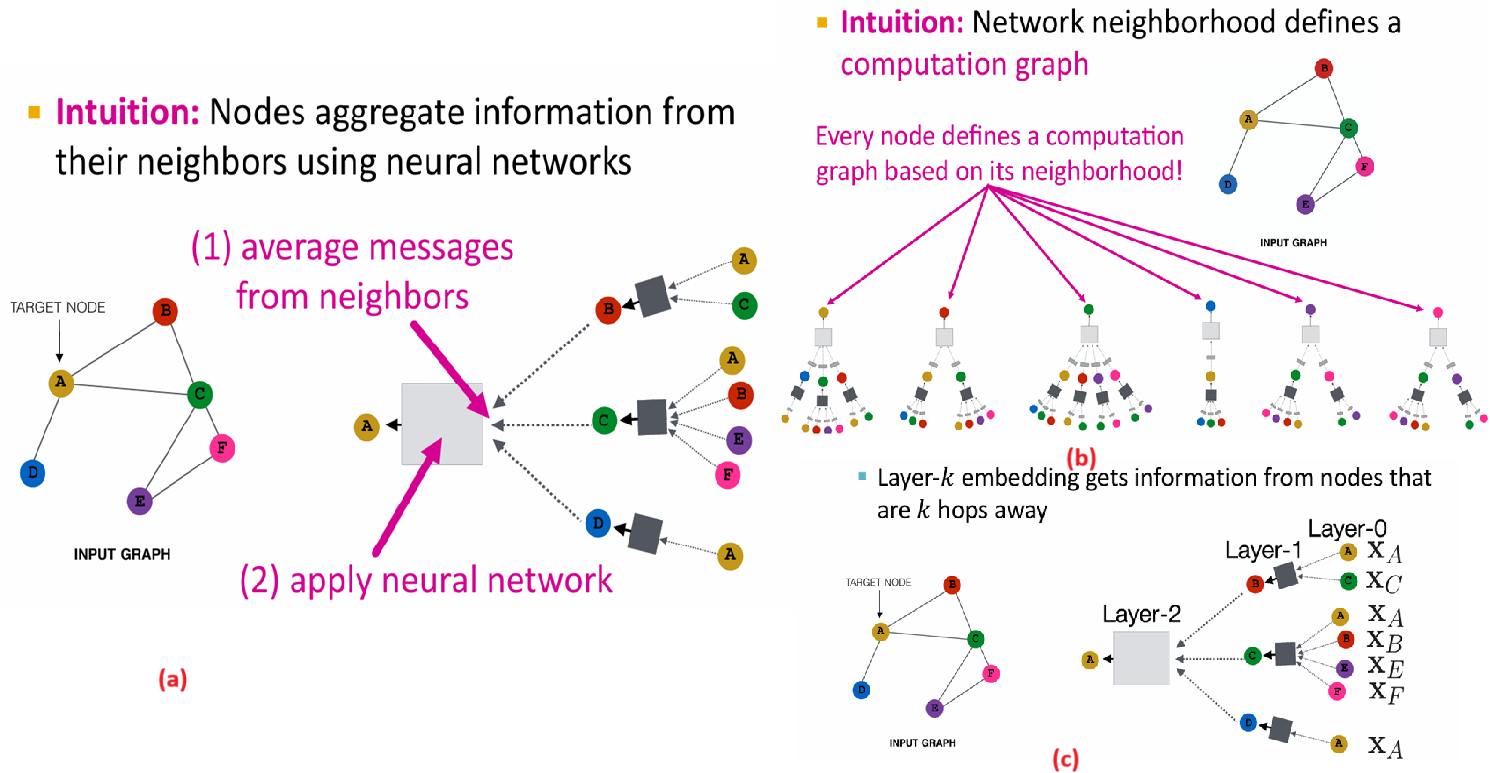

In [10]:
Image(filename='/content/DL_images/GCN_graphic_exp.png', width=900)

Mathematically, information $h_v$ at node v in the layer $k+1$ is a non-linear function $\sigma$ applied to the sum of (a weight matrix $W_k$ of neighborhood aggregation multiplied by the average of the neighbor's previous layer embeddings, to which we add the embedding of node $v$ at layer $k$) (**see image below, subfigures (a) and (b)**).
In a graph convolutional layer, the node's updated feature is computed by considering the features of its neighbors and itself. The update rule is typically of the form
$H^{(l+1)} = \sigma\left(D^{-\frac{1}{2}} A D^{-\frac{1}{2}} H^{(l)} W^{(l)}\right)$ (**see image below, subfigures (c) and (d)**). where:
* represents the features of nodes at layer $l$
* A is the adjacency matrix of the graph, representing the connections between nodes.
* D is the degree matrix, where each entry $D_{ii}$ is the sum of connections for node $i$
* $W_l$ is the weight matrix for the layer.
* $\sigma$ is a non-linear activation function (e.g., ReLU).

GCNs typically consist of multiple layers to enable information propagation across several hops in the graph. Each additional layer allows information to travel further across the graph, allowing the network to learn more complex patterns.

GCN Generate embeddings for nodes as needed even for nodes we never
trained on!(**see image below, subfigures (e)**)


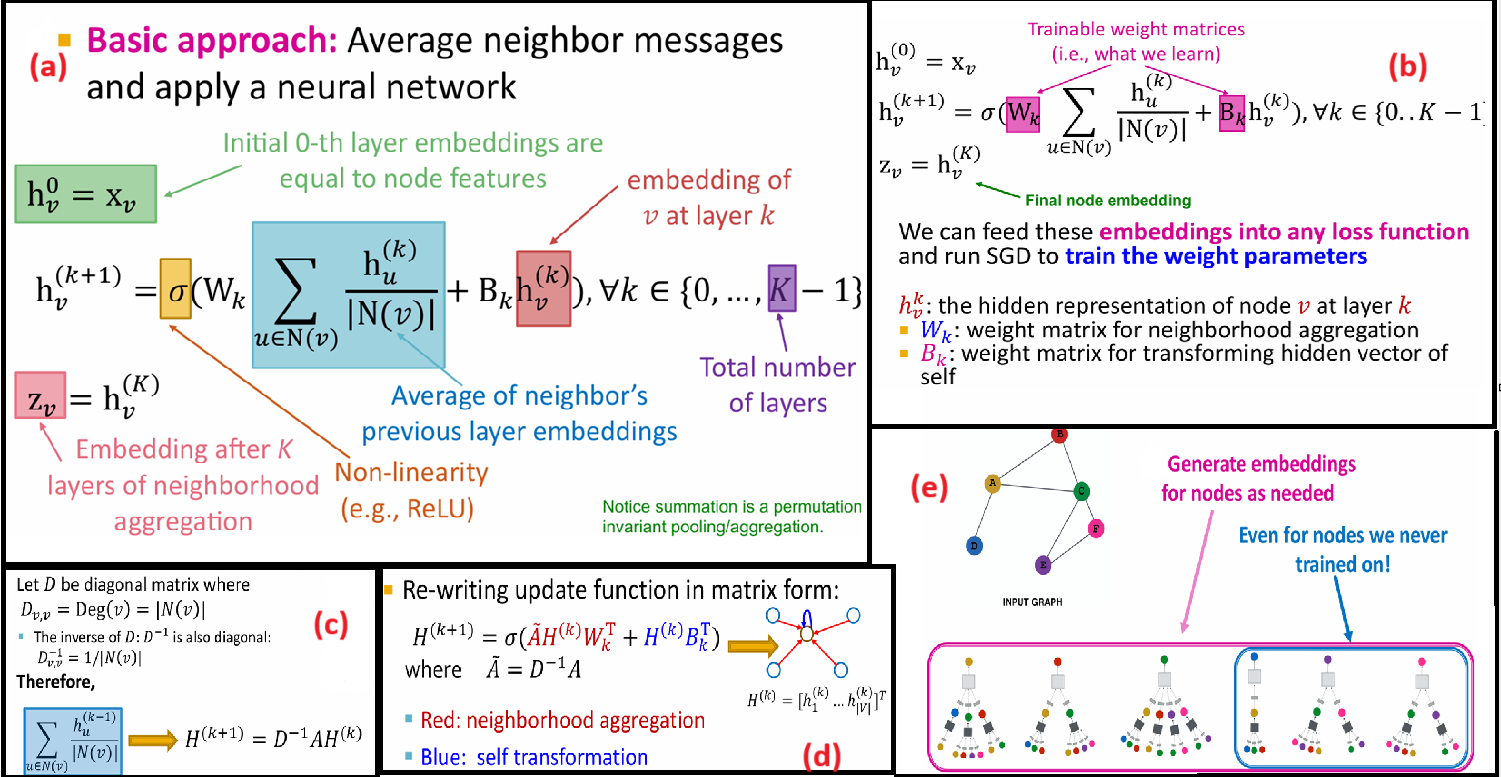

In [11]:
Image(filename='/content/DL_images/GCN_math.png', width=900)

GCN Vs CCN:
CNN can be seen as a special GNN with fixed neighbor
size and ordering:
 • The size of the filter is pre-defined for a CNN.
 • The advantage of GNN is it processes arbitrary
graphs with different degrees for each node.




### Nodes embedding using GCN

**Important disclaimer:** you can use **GPU** to run the next codes to have results fast but you still can use **CPU** if it is easier for you

In [ ]:
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install ogb

We will load and inspect one of the Open Graph Benchmark [(OGB)](https://ogb.stanford.edu/) datasets by using the `ogb` package.

The Open Graph Benchmark (OGB) is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. Its datasets are automatically downloaded, processed, and split using the OGB Data Loader. The model performance can then be evaluated by using the OGB Evaluator in a unified manner.

You can find in ogb documentation how to upload the dataset [here](https://ogb.stanford.edu/docs/nodeprop/)

In [ ]:
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset


dataset_name = 'ogbn-arxiv'
# Load the dataset and transform it to sparse tensor
dataset = PygNodePropPredDataset(name=dataset_name,
                                transform=T.ToSparseTensor())
print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))

# Extract the graph
data = dataset[0]
print(data)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:12<00:00,  6.64it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 5785.25it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 127.65it/s]

Saving...



Done!
/usr/local/lib/python3.11/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

The ogbn-arxiv dataset has 1 graph
Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])


In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F
print(torch.__version__)

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

2.5.1+cu124


Load and Preprocess the Dataset

In [ ]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                transform=T.ToSparseTensor())
data = dataset[0]

# Make the adjacency matrix to symmetric
data.adj_t = data.adj_t.to_symmetric()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

/usr/local/lib/python3.11/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

Device: cpu


We use a list of convolution layers (GCNConv) in a Graph Convolutional Network (GCN) to allow the network to learn multi-hop neighborhood information and extract hierarchical features from the graph.
A single GCN layer aggregates information only from immediate neighbors (1-hop).
Multiple layers allow information to propagate further across the graph.

By stacking layers: lower layers learn local features.
Higher layers learn global features.
This is crucial for learning meaningful graph representations.



With this, we are ready to create our first Graph Convolutional Network by defining our network architecture in a `torch.nn.Module` class

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):


        super(GCN, self).__init__()

        #A list of GCNConv layers
        self.convs = torch.nn.ModuleList()
        #First Layer
        self.convs.append(GCNConv(input_dim, hidden_dim))
        #Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        #Output layer
        self.convs.append(GCNConv(hidden_dim, output_dim))
        self.convs = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)])

        #A list of 1D batch normalization layers
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])

        #LogSoftmax over feature dimension
        self.softmax = torch.nn.LogSoftmax(dim=1)



        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):


        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, adj_t)  # GCN layer applies graph convolution, aggregating information from neighboring nodes
            x = self.bns[i](x)           # Batch normalization
            x = F.relu(x)                # Activation function
            x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout

        x = self.convs[-1](x, adj_t)  # Final layer (no ReLU or dropout)

        if self.return_embeds:
            return x  # Return embeddings

        return self.softmax(x)  # Apply log softmax

In [ ]:
def train(model, data, train_idx, optimizer, loss_fn):

    model.train()
    loss = 0

    optimizer.zero_grad()
    out = model(data.x, data.adj_t)
    loss = loss_fn(out[train_idx], data.y.squeeze(1)[train_idx]) #.squeeze(1) removes the second dimension
    #This is done to match PyTorch expectations, as classification labels are often stored as 1D tensors.

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator):

    model.eval()

    out = model(data.x, data.adj_t)

    # imagine we have two nodes and 3 classes and  out is a raw logit tensor
    #tensor([[ 2.1,  1.3, -0.5],  # Node 0
            #[-1.2,  3.4,  0.9]])  # Node 1
    # we need to take the argmax for each node (line== 1st dimension) according to the classes (2nd dimension)
    y_pred = out.argmax(dim=-1, keepdim=True) #tensor of logits (raw scores before applying softmax) for each node.

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']



    return train_acc, valid_acc, test_acc

In [ ]:
args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}
args

{'device': 'cpu',
 'num_layers': 3,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.01,
 'epochs': 100}

Evaluator is a class provided by the OGB library (ogb.nodeproppred) to standardize evaluation across different datasets.

In [ ]:
model_nodes = GCN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-arxiv')

This is the training loop. It might take **10 minutes to execute** with cpu. You can read it, skip it and use directly a pre-trained model for the sake of time

In [ ]:
# Please do not change these args
# Training should take <10min using GPU runtime
import copy

# reset the parameters to initial random value
model_nodes.reset_parameters()

optimizer = torch.optim.Adam(model_nodes.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  loss = train(model_nodes, data, train_idx, optimizer, loss_fn)
  result = test(model_nodes, data, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model_nodes)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 5.6050, Train: 2.68%, Valid: 2.58% Test: 2.69%
Epoch: 02, Loss: 5.2973, Train: 4.31%, Valid: 4.55% Test: 4.72%
Epoch: 03, Loss: 5.0117, Train: 6.13%, Valid: 7.12% Test: 7.25%
Epoch: 04, Loss: 4.7506, Train: 8.57%, Valid: 10.87% Test: 10.57%
Epoch: 05, Loss: 4.5150, Train: 11.13%, Valid: 14.53% Test: 13.92%
Epoch: 06, Loss: 4.3050, Train: 13.26%, Valid: 17.99% Test: 16.80%
Epoch: 07, Loss: 4.1190, Train: 14.56%, Valid: 20.56% Test: 19.17%
Epoch: 08, Loss: 3.9550, Train: 15.26%, Valid: 22.60% Test: 20.90%
Epoch: 09, Loss: 3.8108, Train: 15.60%, Valid: 23.88% Test: 22.10%
Epoch: 10, Loss: 3.6845, Train: 15.66%, Valid: 24.73% Test: 22.83%
Epoch: 11, Loss: 3.5739, Train: 15.76%, Valid: 25.06% Test: 23.26%
Epoch: 12, Loss: 3.4772, Train: 16.60%, Valid: 25.61% Test: 23.66%
Epoch: 13, Loss: 3.3927, Train: 18.89%, Valid: 26.56% Test: 24.31%
Epoch: 14, Loss: 3.3185, Train: 21.76%, Valid: 27.52% Test: 25.06%
Epoch: 15, Loss: 3.2533, Train: 23.83%, Valid: 28.47% Test: 25.77%
Epoch

You can save your model using the following code

In [ ]:
save_path = "./my_model_nodes.pth"
torch.save(model_nodes.state_dict(), save_path)

If you **saved your model locally** and want to use it, you can run the cell below:

In [ ]:
# Create a new model instance with the same architecture
model_nodes_imported =  GCN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)


# Load saved weights
model_nodes_imported.load_state_dict(torch.load("my_model_nodes.pth"))
model_nodes_imported.eval()  # Set the model to evaluation mode

print("Model successfully loaded!")
model_to_use = model_nodes_imported

**If you did not run the training code** because it might take 10 minutes with cpu, you can directly use the pretrained model to evaluate its accuracy

In [ ]:
model_nodes_imported =  GCN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
model_nodes_imported.load_state_dict(torch.load("/content/DL_images/model_nodes.pth"))
model_nodes_imported.eval()
print("Model successfully loaded!")
model_to_use = model_nodes_imported

Model successfully loaded!


<ipython-input-37-a376b58c936a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_nodes_imported.load_state_dict(torch.load("/content/DL_images/model_nodes.pth"))


Uncomment the line below if you trained your own model to use the best_model saved

In [ ]:
#model_to_use = best_model

In [ ]:
best_result = test(model_to_use, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Best model: Train: 53.85%, Valid: 54.23% Test: 52.24%


### Graph prediction

In this section we will create a graph neural network for graph property prediction (graph classification).

In [ ]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from tqdm.notebook import tqdm

# Load the dataset
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

split_idx = dataset.get_idx_split()

# Check task type
print('Task type: {}'.format(dataset.task_type))

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 91077.26it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 21493.97it/s]


Saving...
Device: cpu
Task type: binary classification


Done!
/usr/local/lib/python3.11/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

In [ ]:
# Load the dataset splits into corresponding dataloaders
# We will train the graph classification task on a batch of 32 graphs
# Shuffle the order of graphs for training set
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:

args = {
    'device': device,
    'num_layers': 5,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 15,
}
args

{'device': 'cpu',
 'num_layers': 5,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.001,
 'epochs': 15}

**Graph Mini-Batching**
Before diving into the actual model, we introduce the concept of mini-batching with graphs. In order to parallelize the processing of a mini-batch of graphs, PyG combines the graphs into a single disconnected graph data object (*torch_geometric.data.Batch*). *torch_geometric.data.Batch* inherits from *torch_geometric.data.Data* (introduced earlier) and contains an additional attribute called `batch`.

The `batch` attribute is a vector mapping each node to the index of its corresponding graph within the mini-batch:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

This attribute is crucial for associating which graph each node belongs to and can be used to e.g. average the node embeddings for each graph individually to compute graph level embeddings.

Now, we have all of the tools to implement a GCN Graph Prediction model!  

We will reuse the existing GCN model to generate `node_embeddings` and then use  `Global Pooling` over the nodes to create graph level embeddings that can be used to predict properties for the each graph. Remeber that the `batch` attribute will be essential for performining Global Pooling over our mini-batch of graphs.

In [ ]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(hidden_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = None


        self.pool = global_mean_pool


        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim) #If output_dim = 1, the model predicts a single property per graph.


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):



        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        #batch: Batch index tensor ([num_nodes]), mapping each node to a graph
        embed = self.node_encoder(x)

        out = None


        embed = self.gnn_node(embed, edge_index)
        out = self.linear(self.pool(embed, batch))

        return out

In [ ]:
def train(model, device, data_loader, optimizer, loss_fn):

    model.train()
    loss = 0

    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
      batch = batch.to(device)

      if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
          pass
      else:
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y


        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out[is_labeled], batch.y[is_labeled].type(torch.float32))


        loss.backward()
        optimizer.step()

    return loss.item()

In [ ]:
# The evaluation function
def eval(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}


    return evaluator.eval(input_dict)

In [ ]:
model_graph = GCN_Graph(args['hidden_dim'],
              dataset.num_tasks, args['num_layers'],
              args['dropout']).to(device)
evaluator = Evaluator(name='ogbg-molhiv')

**Important disclaimer:** This cell may take **15 minutes** (if you are using cpu) to run

In [ ]:
# Please do not change these args
# Training should take <10min using GPU runtime
import copy


model_graph.reset_parameters()

optimizer = torch.optim.Adam(model_graph.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  print('Training...')
  loss = train(model_graph, device, train_loader, optimizer, loss_fn)

  print('Evaluating...')
  train_result = eval(model_graph, device, train_loader, evaluator)
  val_result = eval(model_graph, device, valid_loader, evaluator)
  test_result = eval(model_graph, device, test_loader, evaluator)

  train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model_graph)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.0228, Train: 61.71%, Valid: 61.15% Test: 63.41%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 02, Loss: 0.0453, Train: 66.65%, Valid: 61.70% Test: 60.03%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 03, Loss: 0.0589, Train: 66.37%, Valid: 63.98% Test: 61.71%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 04, Loss: 0.0260, Train: 65.34%, Valid: 60.84% Test: 60.74%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 05, Loss: 0.0486, Train: 65.81%, Valid: 60.66% Test: 60.44%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 06, Loss: 0.0558, Train: 64.83%, Valid: 61.41% Test: 62.10%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 07, Loss: 0.0399, Train: 65.64%, Valid: 62.09% Test: 62.04%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 08, Loss: 0.0497, Train: 66.24%, Valid: 61.37% Test: 61.14%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 09, Loss: 0.0286, Train: 66.19%, Valid: 62.07% Test: 61.82%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.0398, Train: 67.04%, Valid: 61.98% Test: 60.84%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.0181, Train: 67.56%, Valid: 61.98% Test: 60.55%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.6688, Train: 66.61%, Valid: 62.49% Test: 61.98%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.0187, Train: 67.06%, Valid: 61.66% Test: 60.73%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.0278, Train: 67.61%, Valid: 63.46% Test: 61.08%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.0183, Train: 67.06%, Valid: 62.56% Test: 61.72%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.6971, Train: 65.92%, Valid: 61.66% Test: 62.22%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.0318, Train: 67.42%, Valid: 62.68% Test: 61.55%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.0242, Train: 66.66%, Valid: 61.62% Test: 61.82%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.0423, Train: 67.28%, Valid: 61.98% Test: 61.35%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.5293, Train: 67.16%, Valid: 62.44% Test: 61.93%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.1113, Train: 67.20%, Valid: 62.60% Test: 62.20%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.0329, Train: 67.06%, Valid: 62.23% Test: 62.18%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.0280, Train: 66.92%, Valid: 61.43% Test: 61.71%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.5814, Train: 66.91%, Valid: 61.24% Test: 61.80%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.0194, Train: 65.67%, Valid: 62.69% Test: 63.17%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.7729, Train: 67.69%, Valid: 62.38% Test: 61.41%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.0409, Train: 66.98%, Valid: 63.10% Test: 62.95%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.0399, Train: 67.60%, Valid: 63.29% Test: 62.34%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.0378, Train: 67.36%, Valid: 62.91% Test: 60.81%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.0287, Train: 65.48%, Valid: 62.18% Test: 63.72%


Run this cell if you want to save your model

In [ ]:
save_path = "./my_model_graph"
torch.save(model_graph.state_dict(), save_path)

If you have the model **saved locally** you can run the following cell

In [ ]:
# Create a new model instance with the same architecture
model_graph_imported = GCN_Graph(args['hidden_dim'],
              dataset.num_tasks, args['num_layers'],
              args['dropout']).to(device)


# Load saved weights
model_graph_imported.load_state_dict(torch.load("my_model_graph"))
model_graph_imported.eval()  # Set the model to evaluation mode

print("Model successfully loaded!")


Model successfully loaded!


<ipython-input-92-178a65df3574>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_graph_imported.load_state_dict(torch.load("model_graph"))


Otherwise, you can upload **my pre-trained model**:

In [ ]:
model_graph_imported = GCN_Graph(args['hidden_dim'],
              dataset.num_tasks, args['num_layers'],
              args['dropout']).to(device)
model_graph_imported.load_state_dict(torch.load("/content/DL_images/model_graph"))
model_graph_imported.eval()
print("Model successfully loaded!")


Model successfully loaded!


<ipython-input-49-88de6c3cd090>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_graph_imported.load_state_dict(torch.load("/content/DL_images/model_graph"))


In [ ]:
train_auroc = eval(model_graph, device, train_loader, evaluator)[dataset.eval_metric]
valid_auroc = eval(model_graph, device, valid_loader, evaluator)[dataset.eval_metric]
test_auroc  = eval(model_graph, device, test_loader, evaluator)[dataset.eval_metric]

print(f'Best model: '
    f'Train: {100 * train_auroc:.2f}%, '
    f'Valid: {100 * valid_auroc:.2f}% '
    f'Test: {100 * test_auroc:.2f}%')

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Best model: Train: 47.85%, Valid: 48.59% Test: 42.10%


In summary, this GCN for graph:
* Takes a batch of molecular graphs as input.
* Encodes node features using AtomEncoder.
* Uses a GCN (self.gnn_node) to compute node embeddings.
* Aggregates node embeddings into graph-level representations using global pooling.
* Predicts a property (e.g., toxicity, solubility) for each graph

## Sumamry



---


This notebook covered:

* Graph manipulation using NetworkX and PyTorch Geometric.
* Basic node embedding using a similarity-based approach.
* Building a Graph Convolutional Network (GCN) for node-level and graph-level classification with OGB datasets.


---

